In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn.metrics import accuracy_score

Step 0: load our data

In [ ]:
# Load data
data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/MSc thesis/processed_data/metadata/fully_concatenated_data.csv", lineterminator='\n')

In [ ]:
data.iloc[1:10, 28:45]

,Hour,Day of Week (Number),Day of Week (String),Is_English,Detected_Language,Image_Count,image_0,image_1,image_2,image_3,image_4,image_5,image_6,image_7,image_8,image_9,image_10
1,20,6,Sunday,True,en,1,1.257535,4.292836,0.637026,0.038215,0.341019,0.103195,0.023346,0.352497,0.099513,0.015858,0.282103
2,15,6,Sunday,True,en,1,1.015909,4.928564,0.049328,1.360145,0.188817,0.242184,1.370974,0.206735,0.089321,0.008390,0.464875
3,18,2,Wednesday,True,en,7,0.612580,2.573719,0.000000,0.000000,1.416055,0.397631,1.642256,0.049719,0.000707,0.285212,0.627529
4,19,5,Saturday,True,en,1,0.961807,3.994127,0.116529,1.330238,0.034433,2.436250,0.633051,0.620503,3.313558,0.000000,0.139836
5,6,6,Sunday,False,ko,3,0.024685,0.956713,0.100529,0.715106,0.565287,0.084047,0.267570,0.000000,0.030411,0.600792,0.018151
6,15,6,Sunday,False,ko,2,0.000000,1.686701,0.022357,0.000000,0.007881,0.025374,0.328463,0.324222,0.000000,0.042074,0.056771
7,3,6,Sunday,False,ko,10,0.272321,1.318672,0.063117,0.000000,0.127826,0.154153,0.012882,0.257812,0.000000,0.082779,0.027158
8,3,6,Sunday,False,ko,10,1.009356,0.572479,0.049320,0.017962,0.707233,0.036858,0.366499,0.633115,0.058597,0.069269,0.271958
9,21,6,Sunday,True,en,1,1.316597,1.515859,0.067210,2.473874,0.316460,0.163660,0.673739,0.901117,0.219723,1.258277,0.542950


In [ ]:
# List of image and text feature columns to keep
image_columns = [f'image_{i}' for i in range(0, 2049)]
text_columns = [f'text_{i}' for i in range(0, 768)]

# Additional columns you want to keep
additional_columns_to_keep = ['like_count', 'comment_count', 'post_id', 'Followers', 'Username', 'Image_Count']

# Combine both lists of columns to keep
columns_to_keep = text_columns + additional_columns_to_keep #+ image_columns

# Drop all columns except those specified in columns_to_keep
columns_to_drop = [col for col in data.columns if col not in columns_to_keep]

# Drop the unwanted columns from the dataframe
data_2 = data.drop(columns=columns_to_drop)


# Maybe don't delete category and detected languages
# Same with comments disabled and video
# potential columns to add or not:
#'comments_disabled',
#'is_video'
# Category
data_2.head(10)

# Filter image count to 10 or less, which is what is realistic in the industry
data_2 = data_2[data_2['Image_Count'] <= 1]

Step 1: group and split the data by post_id

Define a popularity variable

In [ ]:
# Set the engagement rate variable
data_2['popularity'] = (((data_2['like_count'] + data_2['comment_count'])/data_2['Followers']))

In [ ]:
data_2.head(10)

,Username,post_id,like_count,comment_count,Followers,Image_Count,text_0,text_1,text_2,text_3,...,text_759,text_760,text_761,text_762,text_763,text_764,text_765,text_766,text_767,popularity
0,00_rocketgirl,1354915397698488656,293,6,6453,1,0.038798,-0.013620,-0.028838,-0.157473,...,-0.017703,-0.091135,0.058261,0.159358,0.032952,-0.012526,-0.204870,0.062999,0.075272,0.046335
1,00_rocketgirl,1666974101448132749,73,2,6453,1,0.036927,0.168833,0.037493,-0.280909,...,0.015757,-0.037442,-0.018389,0.203054,0.074983,0.049237,-0.213263,-0.012400,0.147600,0.011623
2,00_rocketgirl,1768273356099895999,164,4,6453,1,0.075085,-0.030041,-0.088772,-0.189933,...,-0.097885,-0.226008,0.053440,0.047846,0.004013,-0.182280,-0.174142,0.094179,0.080168,0.026034
4,00_rocketgirl,1899586748141399903,116,2,6453,1,0.063160,0.008341,-0.013197,-0.210484,...,-0.036261,-0.078814,0.114615,0.149342,0.011751,-0.150317,-0.156846,0.141513,0.093924,0.018286
9,0hkris,1514786978688118458,269,0,12630,1,-0.028073,0.147198,-0.072839,-0.190197,...,-0.036988,-0.208915,0.104713,0.120187,0.093342,0.097392,-0.009471,0.012900,0.064740,0.021298
10,0hkris,1837331879491417999,1065,19,12630,1,0.050338,0.012619,-0.037740,-0.050222,...,-0.165627,0.198171,0.093986,0.176528,0.140797,0.070081,-0.168545,0.107152,0.057365,0.085827
11,0hkris,1840089921320547693,1242,7,12630,1,0.087523,-0.017718,0.045246,-0.324641,...,-0.083701,0.228142,0.049256,0.080081,0.093756,0.086833,-0.163537,0.100750,0.096130,0.098892
12,0hkris,1847365723795798774,1346,4,12630,1,0.129532,-0.088060,0.060749,-0.221060,...,-0.178489,0.159561,-0.046662,0.182022,0.127947,0.299180,-0.091949,0.096147,0.045425,0.106888
13,0ldisme,1653111532051112326,1139,28,18583,1,-0.017063,0.163560,0.079621,-0.038612,...,0.028141,-0.179497,0.085646,0.179977,0.134104,0.239402,0.052813,0.030690,-0.044792,0.062799
14,0ldisme,1708204647056992205,1352,39,18583,1,0.026620,-0.022259,0.029860,0.079999,...,-0.001124,-0.172151,0.021455,0.215737,0.150555,0.408500,-0.234415,0.109303,-0.072184,0.074853


Let's split the data!

In [ ]:
# Define the number of iterations and an array to store accuracies
n_iterations = 7
accuracies = []

for seed in range(n_iterations):
    print(f"Iteration {seed+1}")

    # Split users into training and temporary sets with a new seed each time
    train_users, temp_users = train_test_split(data_2['Username'].unique(), test_size=0.2, random_state=seed)
    val_users, test_users = train_test_split(temp_users, test_size=0.5, random_state=seed)

    # Assign posts to training, validation, and test sets
    train_data = data_2[data_2['Username'].isin(train_users)]
    val_data = data_2[data_2['Username'].isin(val_users)]
    test_data = data_2[data_2['Username'].isin(test_users)]

    # Calculate the median popularity rate for each dataset
    median_popularity_rate_train = train_data['popularity'].quantile(0.5)
    train_data.loc[:, 'popularity'] = (train_data['popularity'] > median_popularity_rate_train).astype(int)
    median_popularity_rate_val = val_data['popularity'].quantile(0.5)
    val_data.loc[:, 'popularity'] = (val_data['popularity'] > median_popularity_rate_val).astype(int)
    median_popularity_rate_test = test_data['popularity'].quantile(0.5)
    test_data.loc[:, 'popularity'] = (test_data['popularity'] > median_popularity_rate_test).astype(int)

    # Prepare data for XGBoost
    X_train = train_data.drop(['popularity', 'post_id', 'like_count', 'comment_count', 'Username', 'Image_Count', 'Followers'], axis=1)
    y_train = train_data['popularity']
    X_val = val_data.drop(['popularity', 'post_id', 'like_count', 'comment_count', 'Username', 'Image_Count', 'Followers'], axis=1)
    y_val = val_data['popularity']
    X_test = test_data.drop(['popularity', 'post_id', 'like_count', 'comment_count', 'Username', 'Image_Count', 'Followers'], axis=1)
    y_test = test_data['popularity']

    # Convert datasets into DMatrix objects
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dval = xgb.DMatrix(X_val, label=y_val)
    dtest = xgb.DMatrix(X_test, label=y_test)

    # Define XGBoost model parameters
    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'error',
        'alpha': 0.9,
        'learning_rate': 0.1
    }

    # Train the model
    eval_list = [(dtrain, 'train'), (dval, 'val')]
    bst = xgb.train(params, dtrain, num_boost_round=500, evals=eval_list, early_stopping_rounds=20)

    # Evaluate the model on the test set
    y_pred_prob = bst.predict(dtest)
    y_pred_binary = (y_pred_prob > 0.5).astype(int)
    accuracy = accuracy_score(y_test, y_pred_binary)
    accuracies.append(accuracy)

    print(f"Accuracy for iteration {seed+1}: {accuracy:.2f}")

# Calculate the average accuracy across all iterations
average_accuracy = np.mean(accuracies)
print(f"Average Accuracy across {n_iterations} iterations: {average_accuracy:.2f}")

Iteration 1
[0]	train-error:0.42559	val-error:0.44722
[1]	train-error:0.41476	val-error:0.44529
[2]	train-error:0.40642	val-error:0.43845
[3]	train-error:0.40322	val-error:0.43785
[4]	train-error:0.39971	val-error:0.43770
[5]	train-error:0.39563	val-error:0.43666
[6]	train-error:0.39149	val-error:0.43599
[7]	train-error:0.38838	val-error:0.43339
[8]	train-error:0.38447	val-error:0.43295
[9]	train-error:0.38202	val-error:0.42804
[10]	train-error:0.37995	val-error:0.42930
[11]	train-error:0.37880	val-error:0.42618
[12]	train-error:0.37510	val-error:0.42492
[13]	train-error:0.37397	val-error:0.42544
[14]	train-error:0.37384	val-error:0.42417
[15]	train-error:0.37180	val-error:0.42373
[16]	train-error:0.37023	val-error:0.42150
[17]	train-error:0.36860	val-error:0.42217
[18]	train-error:0.36725	val-error:0.41964
[19]	train-error:0.36587	val-error:0.42046
[20]	train-error:0.36375	val-error:0.41912
[21]	train-error:0.36233	val-error:0.41853
[22]	train-error:0.36071	val-error:0.42038
[23]	trai

In [ ]:
import numpy as np
from scipy.stats import sem, t
from scipy import mean

# Assuming accuracies are stored in the 'accuracies' list as per previous example
accuracies = np.array(accuracies)

# Calculate the mean accuracy
mean_accuracy = np.mean(accuracies)

# Calculate the standard error of the mean
std_error = sem(accuracies)

# Determine the size of the accuracies array
n = len(accuracies)

# Use the t-distribution to calculate a 95% confidence interval
confidence = 0.95
h = std_error * t.ppf((1 + confidence) / 2, n - 1)

# Print the mean accuracy and confidence interval
print(f"Mean Accuracy: {mean_accuracy:.2f}")
print(f"95% Confidence interval: {mean_accuracy - h:.5f} - {mean_accuracy + h:.5f}")

Mean Accuracy: 0.59
95% Confidence interval: 0.58336 - 0.59082


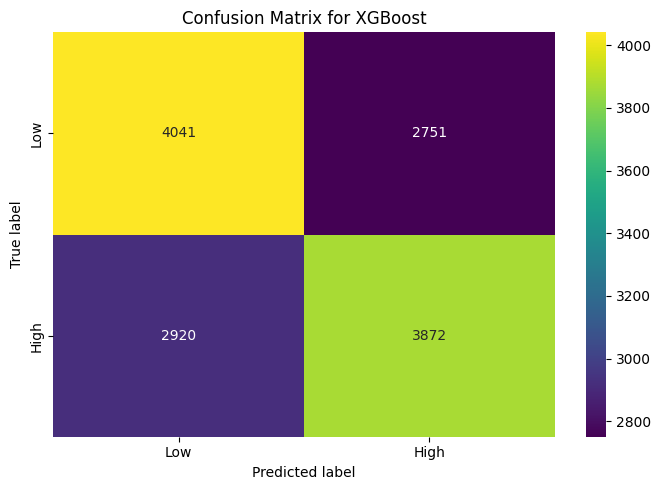

              precision    recall  f1-score   support

         Low       0.58      0.59      0.59      6792
        High       0.58      0.57      0.58      6792

    accuracy                           0.58     13584
   macro avg       0.58      0.58      0.58     13584
weighted avg       0.58      0.58      0.58     13584



In [ ]:
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

def evaluate_model(model, X_test, y_test, type_of_model):
    # Convert X_test to DMatrix for XGBoost prediction
    dtest = xgb.DMatrix(X_test)

    # Predicting the probabilities for the test set
    y_pred_prob = model.predict(dtest)

    # Convert probabilities to binary labels
    y_pred = (y_pred_prob > 0.5).astype(int)

    # y_test should already be binary labels
    y_true = y_test.astype(int)

    # Generating the confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Generating the classification report
    clr = classification_report(y_true, y_pred, target_names=['Low', 'High'])

    # Plotting the confusion matrix
    plt.figure(figsize=(7, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='viridis', xticklabels=['Low', 'High'], yticklabels=['Low', 'High'])
    plt.title(f'Confusion Matrix for {type_of_model}')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

    # Show plot
    plt.show()

    # Print the classification report
    print(clr)

# Example usage assuming X_val is a pandas DataFrame and val_data['popularity'] is the true labels
evaluate_model(bst, X_val, val_data['popularity'], 'XGBoost')

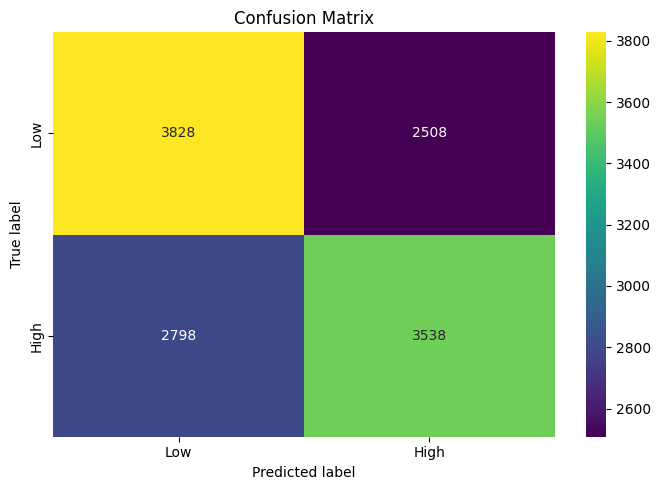

              precision    recall  f1-score   support

         Low       0.58      0.60      0.59      6336
        High       0.59      0.56      0.57      6336

    accuracy                           0.58     12672
   macro avg       0.58      0.58      0.58     12672
weighted avg       0.58      0.58      0.58     12672



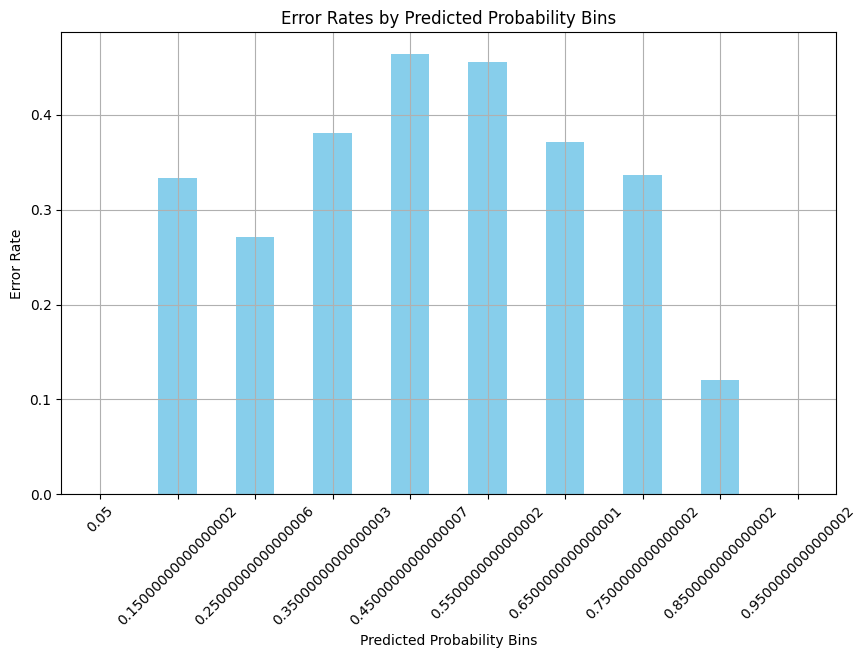

In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

def evaluate_model_and_error_rates(model, X_test, y_test):
    # Convert X_test to DMatrix for XGBoost prediction
    dtest = xgb.DMatrix(X_test)

    # Predicting the probabilities for the test set
    y_pred_prob = model.predict(dtest)

    # Convert probabilities to binary labels
    y_pred = (y_pred_prob > 0.5).astype(int)

    # y_test should already be binary labels
    y_true = y_test.astype(int)

    # Generating the confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Generating the classification report
    clr = classification_report(y_true, y_pred, target_names=['Low', 'High'])

    # Plotting the confusion matrix
    plt.figure(figsize=(7, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='viridis', xticklabels=['Low', 'High'], yticklabels=['Low', 'High'])
    plt.title('Confusion Matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

    # Print the classification report
    print(clr)

    # Calculate error rates by probability bins
    results = pd.DataFrame({
        'y_true': y_true,
        'y_pred_prob': y_pred_prob
    })

    results['prob_bin'] = pd.cut(results['y_pred_prob'], bins=np.arange(0, 1.1, 0.1), labels=np.arange(0.05, 1.05, 0.1))

    # Calculate error rates
    error_rates = results.groupby('prob_bin').apply(
        lambda x: np.mean(x['y_true'] != (x['y_pred_prob'] > 0.5))
    )

    # Plotting error rates by predicted probability bins
    plt.figure(figsize=(10, 6))
    error_rates.plot(kind='bar', color='skyblue')
    plt.title('Error Rates by Predicted Probability Bins')
    plt.xlabel('Predicted Probability Bins')
    plt.ylabel('Error Rate')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.show()

# Example usage, assuming X_test is a pandas DataFrame and test_data['popularity'] is the true labels
evaluate_model_and_error_rates(bst, X_test, test_data['popularity'])